In [ ]:

# Packages for synthetic data generation and pre-processing.  
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import pandas as pd

# Qiskit packages
from qiskit.circuit.library import zz_feature_map,RealAmplitudes
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter, QuantumRegister
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.optimizers import SPSA, ADAM, COBYLA
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import qasm3

# Packages for data visualization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.datasets import make_blobs, make_moons
X, y = make_blobs(n_samples=100, centers=4, n_features=12, cluster_std=0.05, random_state=42)

In [4]:
# train_data, test_data, train_labels, test_labels = train_test_split(X_normalized, y, test_size=0.1, random_state=24)
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=24)

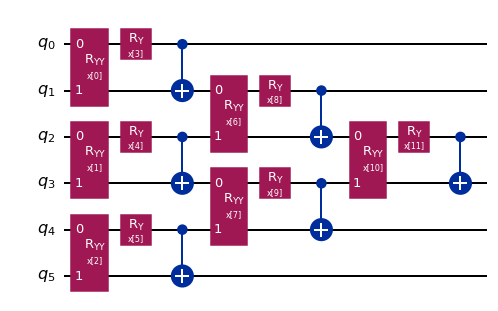

In [5]:
def mera_6_qubits_12_params():
    # 13 trainable parameters
    theta = ParameterVector('x', 12)
    qc = QuantumCircuit(6)

    p = 0  # index for parameter vector

    # Layer 1: Disentanglers (RYY between pairs)
    qc.ryy(theta[p], 0, 1); p += 1
    qc.ryy(theta[p], 2, 3); p += 1
    qc.ryy(theta[p], 4, 5); p += 1

    # Layer 1: Isometries (RY rotations and entangling gates)
    for q in range(0, 6, 2):
        qc.ry(theta[p], q); p += 1
        qc.cx(q, q+1)

    # Layer 2: Disentanglers (across different qubit pairs)
    qc.ryy(theta[p], 1, 2); p += 1
    qc.ryy(theta[p], 3, 4); p += 1

    # Layer 2: Isometries
    for q in [1, 3]:
        qc.ry(theta[p], q); p += 1
        qc.cx(q, q+1)

    # Top layer disentangler
    qc.ryy(theta[p], 2, 3); p += 1

    # Final isometry for central pair
    qc.ry(theta[p], 2); p += 1
    qc.cx(2, 3)

    return qc

# Create and draw the circuit
circuit = mera_6_qubits_12_params()
circuit.draw('mpl')

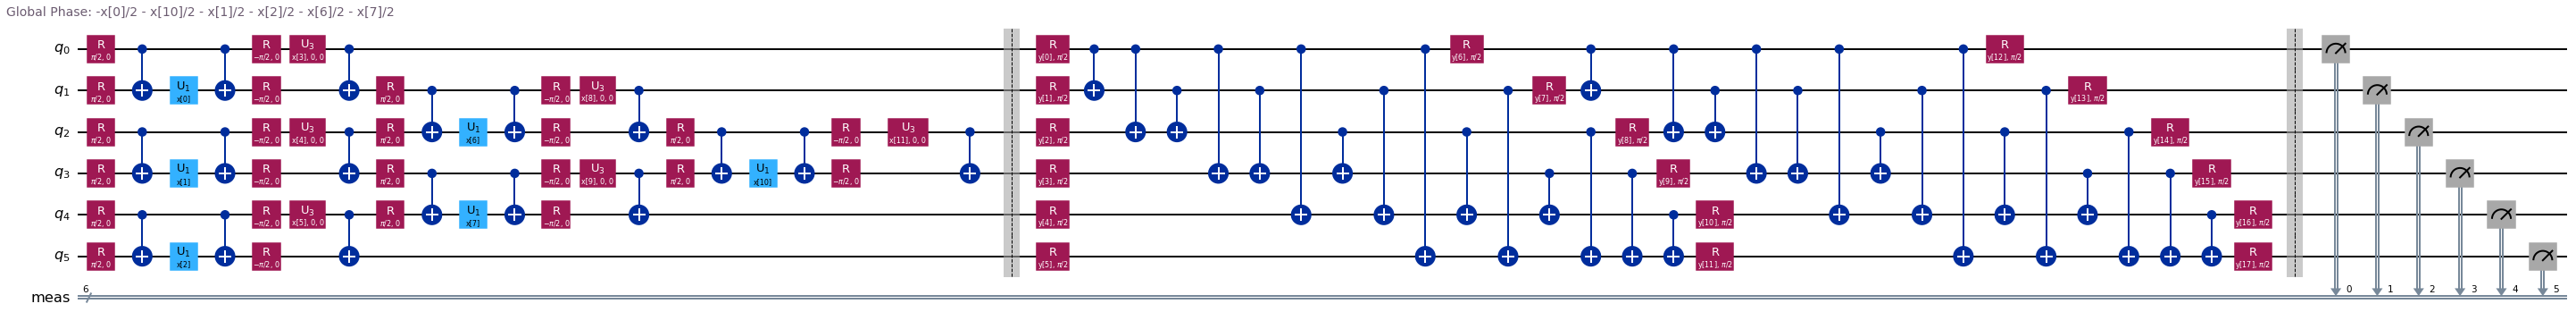

In [6]:
# feature_map = mera_6_qubits_12_params()
feature_map = mera_6_qubits_12_params()
feature_map.barrier()
var_form = RealAmplitudes(num_qubits=6, reps=2,entanglement='full', parameter_prefix='y')
circuit = feature_map.compose(var_form).decompose()
circuit.measure_all()
circuit.decompose().draw(output="mpl", fold=-1, style="iqp")

In [7]:
observables = [('ZZIIII',1),
               ('IIZZII',1),
               ('ZZZZZZ',1),
               ('IIIIZZ',1)]

In [8]:
def labels_probability(results):
    """
    Converts a dictionary of bitstrings and their counts, to parities and their counts
    """
    results = np.array(results)
    results_min = results.min()
    results_max = results.max()
    probabilities = (results - results_min) / (results_max - results_min)
    return probabilities

In [9]:
def multiclass_cross_entropy( y_pred, y_true, epsilon=1e-15):
    """
    Compute the categorical cross-entropy loss.

    Parameters:
        y_true (ndarray): One-hot encoded true labels, shape (n_samples, n_classes)
        y_pred (ndarray): Predicted probabilities, shape (n_samples, n_classes)
        epsilon (float): Small value to avoid log(0)

    Returns:
        float: Mean cross-entropy loss across all samples
    """
    oh = np.zeros(len(observables), dtype=int)
    oh[y_true] = 1
    y_true = oh
    # Clip predictions to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)

    # Compute cross-entropy for each sample
    loss = -np.sum(y_true * np.log(y_pred))

    # Return mean loss
    return np.mean(loss)

In [10]:
def parameters_dictionary(data, variational):
    """
    Assigns parameter values to the quantum circuit.
    """
    parameters = {}
    for param, val in zip(feature_map.parameters, data):
        parameters[param.name] = val 
    for param, val in zip(var_form.ordered_parameters, variational):
        parameters[param.name] = val
        
    return parameters

In [11]:
shot_count = 4096
# from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeAlgiers
# # Get a fake backend from the fake provider
# backend = FakeSherbrooke()
# backend_name = backend.name
# backend_name

# from qiskit_ibm_runtime import QiskitRuntimeService
# # Initialize the runtime service and find the least busy backend
# service = QiskitRuntimeService()
# backend = service.least_busy(min_num_qubits=100, operational=True)
# print(backend.name)
# backend_name = backend.name

In [12]:
def circuit_instance(data, variational):
    """
    Assigns parameter values to the quantum circuit.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = data[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = variational[i]
    return circuit.assign_parameters(parameters)


In [13]:
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator 
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
backend = AerSimulator()
      
# Step 1: Define operator
opp = []
for pauli_string, coeff in observables:
    op = SparsePauliOp.from_list([(pauli_string, coeff)])
    opp.append(op)
 
def classification_probability_simulation(data, variational):
    lst = []
    for d in data:
        circ = circuit_instance(d, variational)      
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(circ)
        isa_observable = [None] * len(opp)
        for i, op in enumerate(opp):
            isa_observable[i] = op.apply_layout(isa_circuit.layout) 
        estimator = Estimator(backend, options={"default_shots": int(2048)})
        job = estimator.run([(isa_circuit, obs) for obs in isa_observable])
        lst.extend([job.result()[i].data.evs.item() for i in range(len(observables))])
    s = len(observables)
    results = [lst[i:i + s] for i in range(0, len(lst), s)]   
    classification = [labels_probability(results[i]) for i, _ in enumerate(data)]
    return classification

In [14]:
def cost_function(data, labels, variational):
    """
    Evaluates performance of our circuit with variational parameters on data.
    """
    classifications = classification_probability_simulation(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += multiclass_cross_entropy(classification, labels[i])
    cost /= len(data)
    return cost


In [15]:
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    # return cost_function(train_data.values, train_labels.values, variational)

    return cost_function(train_data, train_labels, variational)

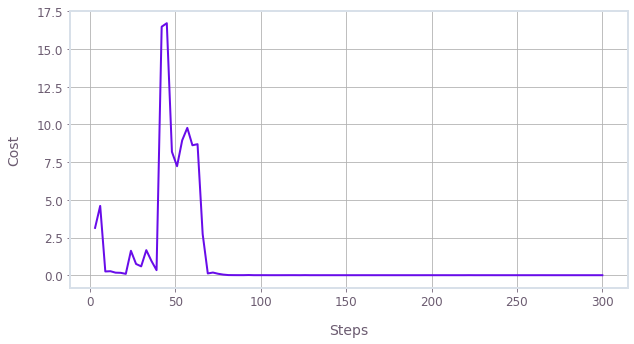

In [16]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        self.stepsizes = []
        self.accepts = []
    def update(self, evaluation, parameter=None, cost=None, _stepsize=None, _accept=None):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        self.stepsizes.append(_stepsize)
        self.accepts.append(_accept)
             
# Set up the optimization
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.zeros((var_form.num_parameters))

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.grid(True)
plt.rc('axes', linewidth=2)  # Set the axes linewidth globally
ax = plt.gca()  # Get current axes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.show()

In [17]:
def create_conf_mat(y_true, y_pred, title):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a custom colormap
    colors = [(1, 1, 1), (98/255, 35/255, 223/255)]  # White to blue
    n_bins = 100  # Number of bins in the colormap
    cmap_name = 'custom_blue'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Display confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=custom_cmap)

    # Add color bar
    fig.colorbar(cax)

    # Set predefined RGB color for the text
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            color = 'white' if i == j else 'black'
            ax.text(j, i, f'{cm_normalized[i, j]:.1f}%', va='center', ha='center', color=color)

    # Set predefined background color for the diagonal elements (e.g., RGB (255, 255, 0))
    diagonal_color = (98/255, 35/255, 223/255)  # Normalize to 0-1 range
    for i in range(cm_normalized.shape[0]):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=True, color=diagonal_color, alpha=0.3))

    # Set predefined background color for the plot (e.g., RGB (240, 240, 240))
    background_color = (1, 1, 1)  # Normalize to 0-1 range
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [18]:
# opt_var = [ 0.84176026, -0.22831505, -0.4861515 , -1.63393109,  2.22971488,
#        -0.64814932, -0.01510327, -2.63114952,  1.06593608, -0.66322429,
#         0.5534776 , -0.66315454, -0.48244265,  0.04734067, -0.54197608,
#         2.62146945, -0.10174802, -0.12481687]

Simulated Test Accuracy: 100.00%


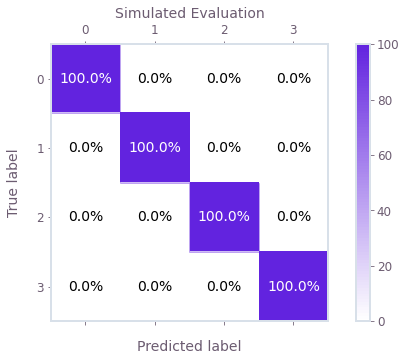

In [19]:
def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_simulation(data, variational)
    predictions = [np.argmax(p) for p in probability]

    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Simulated Test Accuracy: {accuracy * 100:.2f}%")
    create_conf_mat(labels, predictions, "Simulated Evaluation")
    return accuracy, predictions

accuracy_sim, predictions_sim = test_classifier(test_data, test_labels, opt_var)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [27]:
service = QiskitRuntimeService()
backend_name = 'ibm_brisbane'
backend = service.backend(backend_name)

In [28]:
def classification_probability_qiskit(data, variational):
    lst = []
    for d in data:
        circ = circuit_instance(d, variational)      
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(circ)

        isa_observable = [None] * len(opp)

        for i, op in enumerate(opp):
            isa_observable[i] = op.apply_layout(isa_circuit.layout) 

        estimator = Estimator(backend, options={"default_shots": int(4096)})
        job = estimator.run([(isa_circuit, obs) for obs in isa_observable])
        lst.extend([job.result()[i].data.evs.item() for i in range(len(observables))])
    s = len(observables)
    results = [lst[i:i + s] for i in range(0, len(lst), s)]   
    classification = [labels_probability(results[i]) for i, _ in enumerate(data)]  
    return classification

Qiskit Test Accuracy: 30.00%


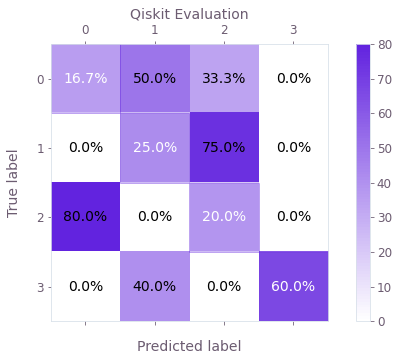

In [30]:
def test_classifier(data, labels, variational):
    """
    Gets classifier'spredictions and calculates accuracy 
    """
    probability = classification_probability_qiskit(data, variational)
    predictions = [np.argmax(p) for p in probability]

    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    print(f"Qiskit Test Accuracy: {accuracy * 100:.2f}%")
    create_conf_mat(labels, predictions, "Qiskit Evaluation")
    return accuracy, predictions

accuracy_def, predictions_def = test_classifier(test_data, test_labels, opt_var)